# **Práctica 4**: Regresión polinomial
## Especificaciones:
El *dataset* a utilizar en esta práctica es el de cal_housing.csv
- Las columnas *longitude, latitude, housingMedianAge, totalRooms, totalBedrooms, population, households, medianIncome* son las características de las casas.
- La columna *medianHouseValue* es el valor a predecir.

Con el dataset especificado realice lo siguiente:

- Cargue el dataset
- Genere un conjunto de entrenamiento con 80% de los datos y 20% para las pruebas
- Mezcle los datos con semilla 0
- Con el conjunto de entrenamiento, genere un conjunto de validación de 10 pliegues


In [41]:
import pandas as pd
import numpy as np
import operator
import os
from tabulate import tabulate


import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
class validation_set:
  def __init__(self, X_train, y_train, X_test, y_test):
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test

In [3]:
class test_set:
  def __init__(self, X_test, y_test):
    self.X_test = X_test
    self.y_test = y_test

In [4]:
class data_set:
  def __init__(self, validation_set, test_set):
    self.validation_set = validation_set
    self.test_set = test_set

In [5]:
def pliegues_validacion(pliegues, folder):
  # url = 'https://firebasestorage.googleapis.com/v0/b/portafoliowebsite.appspot.com/o/Notas%20Amatsu%2Fcal_housing.csv?alt=media&token=476a6d9d-ca90-42ba-9ab6-1dbfd9babdea'
  url = './dataset/cal_housing.csv'
  df = pd.read_csv(url, sep=',', engine='python')

  # corpus
  X = df[df.columns[0:8].values]
  # target
  y = df['medianHouseValue']
    
  #Separa corpus en conjunto de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=0)

  validation_sets = []

  # Número de pliegues
  kf = KFold(n_splits=pliegues)
  c = 0

  for train_index, test_index in kf.split(X_train):
    c = c + 1
    i = 1
    X_train_v, X_test_v = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_v, y_test_v = y_train.iloc[train_index], y_train.iloc[test_index]
    
    #Agrega el pliegue creado a la lista
    validation_sets.append(validation_set(X_train_v, y_train_v, X_test_v, y_test_v))

    #Almacena el conjunto de prueba
    my_test_set = test_set(X_test, y_test)	
      
    #Guarda el dataset con los pliegues del conjunto de validación y el conjunto de pruebas
    my_data_set = data_set(validation_sets, my_test_set)

    my_data_set.test_set.X_test.to_csv(folder + 'data_test.csv', index = False)
    my_data_set.test_set.y_test.to_csv(folder + 'target_test.csv', index = False)

    cad_pliegues = str(pliegues) + '_'

    for val_set in my_data_set.validation_set:
      cad_i = str(i)
      val_set.X_train.to_csv(folder + 'data_validation_train_'+ cad_pliegues + cad_i + '.csv', index = False)
      val_set.y_train.to_csv(folder + 'target_validation_train_'+ cad_pliegues + cad_i+ '.csv', index = False)
      val_set.X_test.to_csv(folder + 'data_test_'+ cad_pliegues + cad_i+ '.csv', index = False)
      val_set.y_test.to_csv(folder + 'target_test_'+ cad_pliegues + cad_i + '.csv', index = False)
      i = i + 1
  print('Terminado los 10 pliegues')

In [6]:
k = 10
path = 'pliegues/'
# pliegues_validacion(k, path)

Usando el conjunto de entrenamiento realice lo siguiente con cada pliegue:

1. Utilice **regresión lineal mediante gradiente descendiente estocástico** para generar una línea que se ajuste lo mejor posible a los datos (modificando parámetros *max_iter, learning_rate y eta0*) y reporte el error cuadrado medio (MSE) y el coeficiente de determinación ($r^2$)


In [7]:
name_files = os.listdir('pliegues/')

In [8]:
data_train = list(filter(lambda x: x.startswith('data_validation_train'), name_files))
target_train = list(filter(lambda x: x.startswith('target_validation_train'), name_files))
print(len(data_train), len(target_train))

10 10


In [43]:
mse_list = []
r2_list = []

In [86]:
def sgdregressor (grade, x, y, learning, eta = 0.01, color = 'g', max = int(), i = int(), robusto = False, estandar = False, grafica = False):
  """
  grade : grado de la regresión polinomial
  x : datos de x
  y : datos de y
  learning : metodo de aprendizaje del SDGRegresor (constant, optimal, invscaling, adaptive)
  eta : valor de eta0 (defecto 0.01)
  max : número maximo de iteraciones
  color : posición de un vector con nombres de colores
  i : número de iteración
  robusto : valor boleano para ver si se escalan o no los datos
  estandar : valor booleano para ver si se escalan o no los datos
  """

  polynomial_features= PolynomialFeatures(degree=grade)
  x_poly = polynomial_features.fit_transform(x)


  if robusto:
    x_poly = preprocessing.RobustScaler().fit_transform(x_poly)


  if estandar:
    x_poly = preprocessing.StandardScaler().fit_transform(x_poly)

      
  regr = SGDRegressor(learning_rate = learning, eta0 = eta, max_iter= max)
  regr.fit(x_poly, y.values.ravel())

  y_poly_pred = regr.predict(x_poly)
  mse = mean_squared_error(y, y_poly_pred)
  r2 = r2_score(y, y_poly_pred)

  print('r='+str(r2))
  print('mse='+str(mse))

  mse_list.append(mse)
  r2_list.append(r2)

  # Ajustes para que la curva trazada se vea correctamente
  sort_axis = operator.itemgetter(0)
  sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)

  x_sorted, y_poly_pred = zip(*sorted_zip)
  print(pd.DataFrame({'x': np.reshape(x_sorted,(1,-1))[0], 'Predicted': y_poly_pred}))

  if grafica:
    plt.plot(x_sorted, y_poly_pred, color='b')


In [11]:
def itera(grado, val_ap, val_e, val_itera, robusto = False, normal = False):

  colores = ['red', 'gray', 'green', 'black', 'orange', 'teal', 'yellow', 'coral', 'palegreen', 'aqua', 'cyan']

  for i, file in enumerate(data_train):

    print('Grado '+ str(grado) + ' k='+str(i))

    x = pd.read_csv(path + file)
    y = pd.read_csv(path + 'target_validation_train_10_'+ file[25:-4] + '.csv')

    sgdregressor(grado,x, y, val_ap, val_e, colores[i], val_itera, i, robusto= robusto, estandar = normal)

In [46]:
def calculo_promedio(lista = list(), learning_rate = list(), grados = list()):
    """
    Función para calcular el promedio de cada celda, hay que reiniciar las listas despues de llamar a esta función
    lista : lista donde se almacena el valor de mse o r2
    learning_rate: lista de valores que se uso para calcular el mse o el r2
    grados : lista de valores que se uso para el calculo de mse o r2
    """
    # Variables necesarias
    inicio = 0
    final = 10

    # Vector de resultados
    promedio = []

    # Calculo de promedio
    for learning in learning_rate:
        for grado in grados:
            promedio.append(np.mean(np.array(lista[inicio: final])))
            inicio +=10
            final += 10

    return promedio

In [80]:
def crea_tabla(vector_mse = list(), vector_r2 = list(), grados = int(), metodo = str(), iteraciones = int(), robusto = False, normal = False):
    """
    Creamos la tabla que se requiere para la entrega final.
    vector_mse : vector de promedios del error cuadratico
    vector_r2 : vector de promedios del r2
    grado : grado utilizado para el calculo
    metodo : lsita de la forma de aprender
    iteraciones : número de iteraciones que se uso para entrenar el modelo
    robusto : si se utilizo escalamiento o no
    normal : si se utilizo un escalado normal
    """
    escalado = 'no_escalado'

    if robusto:
        escalado = 'escalado_robusto'
    
    if normal:
        escalado = 'escalado_normal'

    vec = []
    i = 0
    for meto in metodo:
        for grado in grados:
            # print(meto, grado, i)
            vec.append([str(grado),str(escalado),str(meto),str(iteraciones),str(vector_mse[i]),str(vector_r2[i])])
            i += 1
    
    print(tabulate(vec,headers=['Tipo de regresion','Tipo de escalamiento', 'Learning rate utilizado', 'Número de iteraciones utilizadas', 'MSE promedio', 'r2 promedio'],tablefmt="grid", numalign="center"))

Después de definir las funciónes necesarias, vamos e empezar con el calculo de la regresión lineal de primer grado

2. Utilice **regresión polinomial mediante el gradiente descendiente estocástico** con poinomios de grado **2 y 3** para generar una línea curva que se ajuste lo mejor posible a los datos (modificando parámetros *max_iter, learning_rate y eta0*), y reporte MSE y $r^2$.


In [44]:
learning_rate =['constant', 'adaptive']
grados = [1, 2, 3]
iter_max = 10000
eta = 0.000001

for learning in learning_rate:
    for grado in grados:
        print(grado, learning)
        itera(grado, learning, eta, iter_max)

1 constant
Grado 1 k=0
                  x     Predicted
0        households -9.385653e+12
1  housingMedianAge -6.615303e+12
2          latitude -3.483867e+12
3         longitude -4.432080e+12
4      medianIncome -2.264909e+13
5        population -5.569321e+12
6     totalBedrooms -3.538010e+12
7        totalRooms -4.738953e+12
Regresión polinomial estocástico grado 1
mse: 6.356261708806333e+25 r2: -4769097727115651.0
Grado 1 k=1
                  x     Predicted
0        households -1.004932e+12
1  housingMedianAge  1.681628e+12
2          latitude  3.091968e+12
3         longitude  5.829392e+10
4      medianIncome -4.114539e+12
5        population -1.109802e+11
6     totalBedrooms  1.699104e+11
7        totalRooms  2.482051e+12
Regresión polinomial estocástico grado 1
mse: 1.872476074107809e+25 r2: -1398043332585786.8
Grado 1 k=2
                  x     Predicted
0        households -6.688507e+12
1  housingMedianAge -1.083823e+13
2          latitude -1.537699e+13
3         longitude -

Calculamos el promedio de esta iteracion y reportamos resultados.

In [72]:
promedio_mse_sin_escalado = calculo_promedio(mse_list, learning_rate, grados)
promedio_r2_sin_escalado = calculo_promedio(r2_list, learning_rate, grados)

crea_tabla(promedio_mse_sin_escalado, promedio_r2_sin_escalado, grados, learning_rate, iter_max)
# promedio_mse

+---------------------+------------------------+---------------------------+------------------------------------+----------------+---------------+
|  Tipo de regresion  | Tipo de escalamiento   | Learning rate utilizado   |  Número de iteraciones utilizadas  |  MSE promedio  |  r2 promedio  |
+=====================+========================+===========================+====================================+================+===============+
|          1          | escalado_normal        | constant                  |               10000                |  3.45221e+26   | -2.57926e+16  |
+---------------------+------------------------+---------------------------+------------------------------------+----------------+---------------+
|          2          | escalado_normal        | constant                  |               10000                |  8.09585e+43   | -6.05606e+33  |
+---------------------+------------------------+---------------------------+------------------------------------+-----

Tenemos que reiniciar las listas para poder calcular el promedio correctamente. Ahora se va a calcular lo mismo pero con escalado estandar

In [75]:
mse_list = []
r2_list = []

In [76]:
learning_rate =['constant', 'adaptive']
grados = [1, 2, 3]
iter_max = 10000
eta = 0.000001

for learning in learning_rate:
    for grado in grados:
        print(grado, learning)
        itera(grado, learning, eta, iter_max, normal=True)

1 constant
Grado 1 k=0
                  x      Predicted
0        households  353212.644851
1  housingMedianAge  216781.295501
2          latitude  361120.341387
3         longitude  314917.589472
4      medianIncome  326469.456894
5        population  266694.348368
6     totalBedrooms  267077.645266
7        totalRooms   63147.161490
Regresión polinomial estocástico grado 1
mse: 4795212959.137449 r2: 0.6402155815457674
Grado 1 k=1
                  x      Predicted
0        households  247247.080817
1  housingMedianAge  215277.776204
2          latitude  280748.682688
3         longitude  175388.461822
4      medianIncome  462587.310070
5        population  440009.013708
6     totalBedrooms  244944.381785
7        totalRooms  124478.167413
Regresión polinomial estocástico grado 1
mse: 4875983617.989502 r2: 0.6359453409744735
Grado 1 k=2
                  x      Predicted
0        households  246975.512087
1  housingMedianAge  215150.728896
2          latitude  280129.284762
3        

Calculamos el promedio de la iteración con datos escalados.

In [77]:
promedio_mse_escalado_estandar = calculo_promedio(mse_list, learning_rate, grados)
promedio_r2_escalado_estandar = calculo_promedio(r2_list, learning_rate, grados)

crea_tabla(promedio_mse_escalado_estandar, promedio_r2_escalado_estandar, grados, learning_rate, iter_max, normal=True)
# promedio_mse

+---------------------+------------------------+---------------------------+------------------------------------+----------------+---------------+
|  Tipo de regresion  | Tipo de escalamiento   | Learning rate utilizado   |  Número de iteraciones utilizadas  |  MSE promedio  |  r2 promedio  |
+=====================+========================+===========================+====================================+================+===============+
|          1          | escalado_normal        | constant                  |               10000                |  4.82703e+09   |   0.639332    |
+---------------------+------------------------+---------------------------+------------------------------------+----------------+---------------+
|          2          | escalado_normal        | constant                  |               10000                |  4.35385e+09   |   0.674689    |
+---------------------+------------------------+---------------------------+------------------------------------+-----

In [78]:
learning_rate =['constant', 'adaptive']
grados = [1, 2, 3]
iter_max = 10000
eta = 0.000001

for learning in learning_rate:
    for grado in grados:
        print(grado, learning)
        itera(grado, learning, eta, iter_max, robusto=True)

1 constant
Grado 1 k=0


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  351254.120759
1  housingMedianAge  219767.927155
2          latitude  366030.252047
3         longitude  314239.517451
4      medianIncome  324049.579120
5        population  264347.201785
6     totalBedrooms  266605.683127
7        totalRooms   64389.593980
Regresión polinomial estocástico grado 1
mse: 4800857199.050018 r2: 0.6397920947075677
Grado 1 k=1


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  247342.535526
1  housingMedianAge  214783.553882
2          latitude  279747.534320
3         longitude  174816.479342
4      medianIncome  461659.759749
5        population  442084.924354
6     totalBedrooms  245440.782192
7        totalRooms  122978.949496
Regresión polinomial estocástico grado 1
mse: 4881833593.800429 r2: 0.6355085653172916
Grado 1 k=2


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  247002.786671
1  housingMedianAge  214658.244234
2          latitude  279300.950595
3         longitude  175138.470664
4      medianIncome  459945.760577
5        population  440929.943960
6     totalBedrooms  244831.859585
7        totalRooms  123227.204157
Regresión polinomial estocástico grado 1
mse: 4870946648.947865 r2: 0.6358944620806688
Grado 1 k=3


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  247477.009370
1  housingMedianAge  214616.142389
2          latitude  279461.811236
3         longitude  174750.178780
4      medianIncome  461529.494528
5        population  442066.214383
6     totalBedrooms  245299.429580
7        totalRooms  122903.187452
Regresión polinomial estocástico grado 1
mse: 4813616414.455693 r2: 0.640047179875261
Grado 1 k=4


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  247263.138271
1  housingMedianAge  214807.165406
2          latitude  278020.658003
3         longitude  176126.052994
4      medianIncome  461116.284999
5        population  441993.877642
6     totalBedrooms  244827.628028
7        totalRooms  122822.854747
Regresión polinomial estocástico grado 1
mse: 4858748869.840307 r2: 0.6365345668371403
Grado 1 k=5


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  246934.020025
1  housingMedianAge  214034.774425
2          latitude  280333.545770
3         longitude  173680.818266
4      medianIncome  462801.786531
5        population  442533.984029
6     totalBedrooms  245138.335054
7        totalRooms  121661.327190
Regresión polinomial estocástico grado 1
mse: 4765702566.331242 r2: 0.6430618013187512
Grado 1 k=6


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  247538.124725
1  housingMedianAge  214897.101037
2          latitude  279563.386991
3         longitude  175230.193107
4      medianIncome  461339.091571
5        population  440957.951507
6     totalBedrooms  245539.644694
7        totalRooms  123332.398716
Regresión polinomial estocástico grado 1
mse: 4833947320.60526 r2: 0.637810695116173
Grado 1 k=7


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  246955.892785
1  housingMedianAge  214352.545322
2          latitude  279122.767115
3         longitude  174869.724142
4      medianIncome  461879.507283
5        population  441288.449966
6     totalBedrooms  244607.745303
7        totalRooms  122740.214324
Regresión polinomial estocástico grado 1
mse: 4859628785.096916 r2: 0.6387791728032237
Grado 1 k=8


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  246390.954366
1  housingMedianAge  214722.273640
2          latitude  279230.844045
3         longitude  175636.151986
4      medianIncome  460629.345589
5        population  441305.101841
6     totalBedrooms  244402.222463
7        totalRooms  122574.151636
Regresión polinomial estocástico grado 1
mse: 4856354136.699413 r2: 0.6370677258487512
Grado 1 k=9


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  249701.956964
1  housingMedianAge  215813.835000
2          latitude  276289.990647
3         longitude  178238.519364
4      medianIncome  462412.147031
5        population  441870.060978
6     totalBedrooms  247074.637770
7        totalRooms  123850.378003
Regresión polinomial estocástico grado 1
mse: 4784519888.345258 r2: 0.6446454562925796
2 constant
Grado 2 k=0
                  x      Predicted
0        households  338262.730128
1  housingMedianAge  234942.265070
2          latitude  375727.664196
3         longitude  324467.394768
4      medianIncome  346324.913807
5        population  253062.602821
6     totalBedrooms  274515.976196
7        totalRooms   76570.502436
Regresión polinomial estocástico grado 2
mse: 4784137871.033395 r2: 0.6410465444595737
Grado 2 k=1
                  x      Predicted
0        households  263316.303883
1  housingMedianAge  214205.788256
2          latitude  277805.604076
3         longitude  

c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  351253.889948
1  housingMedianAge  219767.919135
2          latitude  366030.436174
3         longitude  314239.383520
4      medianIncome  324047.540206
5        population  264347.231024
6     totalBedrooms  266605.636733
7        totalRooms   64389.558065
Regresión polinomial estocástico grado 1
mse: 4800857192.325486 r2: 0.6397920952121088
Grado 1 k=1


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  247340.242090
1  housingMedianAge  214783.561098
2          latitude  279749.565639
3         longitude  174812.805949
4      medianIncome  461675.651093
5        population  442086.446722
6     totalBedrooms  245442.270061
7        totalRooms  122975.785844
Regresión polinomial estocástico grado 1
mse: 4881833613.86015 r2: 0.6355085638195765
Grado 1 k=2


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  247000.680017
1  housingMedianAge  214657.723892
2          latitude  279302.135461
3         longitude  175134.313080
4      medianIncome  459958.954857
5        population  440930.242969
6     totalBedrooms  244833.182816
7        totalRooms  123224.336160
Regresión polinomial estocástico grado 1
mse: 4870946604.910699 r2: 0.6358944653724675
Grado 1 k=3


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  247476.170451
1  housingMedianAge  214615.841085
2          latitude  279461.539467
3         longitude  174749.471773
4      medianIncome  461532.384192
5        population  442066.720442
6     totalBedrooms  245299.102833
7        totalRooms  122902.063960
Regresión polinomial estocástico grado 1
mse: 4813616395.365203 r2: 0.6400471813028106
Grado 1 k=4


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  247259.555284
1  housingMedianAge  214806.302846
2          latitude  278021.237438
3         longitude  176120.343718
4      medianIncome  461133.440207
5        population  441993.387525
6     totalBedrooms  244828.947270
7        totalRooms  122818.778720
Regresión polinomial estocástico grado 1
mse: 4858748960.717215 r2: 0.6365345600389675
Grado 1 k=5


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  246938.984033
1  housingMedianAge  214035.614765
2          latitude  280332.093554
3         longitude  173688.930867
4      medianIncome  462773.977826
5        population  442534.391630
6     totalBedrooms  245135.775371
7        totalRooms  121667.194230
Regresión polinomial estocástico grado 1
mse: 4765702468.14065 r2: 0.6430618086729603
Grado 1 k=6


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  247542.924630
1  housingMedianAge  214897.605297
2          latitude  279560.094300
3         longitude  175239.325698
4      medianIncome  461308.792912
5        population  440958.489539
6     totalBedrooms  245535.949445
7        totalRooms  123337.961786
Regresión polinomial estocástico grado 1
mse: 4833947457.1089325 r2: 0.6378106848884715
Grado 1 k=7


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  246953.222463
1  housingMedianAge  214352.152157
2          latitude  279124.684181
3         longitude  174864.980219
4      medianIncome  461895.259543
5        population  441289.257217
6     totalBedrooms  244609.241409
7        totalRooms  122736.829433
Regresión polinomial estocástico grado 1
mse: 4859628801.119068 r2: 0.6387791716122819
Grado 1 k=8


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  246389.888993
1  housingMedianAge  214722.017784
2          latitude  279230.480438
3         longitude  175634.367075
4      medianIncome  460633.666613
5        population  441304.707824
6     totalBedrooms  244402.622153
7        totalRooms  122573.149170
Regresión polinomial estocástico grado 1
mse: 4856354128.379065 r2: 0.6370677264705599
Grado 1 k=9


c:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


                  x      Predicted
0        households  249705.218675
1  housingMedianAge  215814.502269
2          latitude  276288.064018
3         longitude  178244.296733
4      medianIncome  462391.278318
5        population  441868.231697
6     totalBedrooms  247072.933641
7        totalRooms  123855.257561
Regresión polinomial estocástico grado 1
mse: 4784519917.147446 r2: 0.6446454541533915
2 adaptive
Grado 2 k=0
                  x      Predicted
0        households  337891.642417
1  housingMedianAge  235287.845105
2          latitude  376542.305626
3         longitude  323334.575356
4      medianIncome  345298.064755
5        population  251358.663467
6     totalBedrooms  273718.805844
7        totalRooms   77823.788806
Regresión polinomial estocástico grado 2
mse: 4820544915.414622 r2: 0.6383149270315349
Grado 2 k=1
                  x      Predicted
0        households  264099.836015
1  housingMedianAge  215038.754814
2          latitude  278894.489278
3         longitude  

In [81]:
promedio_mse_escalado_robusto = calculo_promedio(mse_list, learning_rate, grados)
promedio_r2_escalado_robusto = calculo_promedio(r2_list, learning_rate, grados)

crea_tabla(promedio_mse_escalado_robusto, promedio_r2_escalado_robusto, grados, learning_rate, iter_max, robusto=True)

+---------------------+------------------------+---------------------------+------------------------------------+----------------+---------------+
|  Tipo de regresion  | Tipo de escalamiento   | Learning rate utilizado   |  Número de iteraciones utilizadas  |  MSE promedio  |  r2 promedio  |
+=====================+========================+===========================+====================================+================+===============+
|          1          | escalado_robusto       | constant                  |               10000                |  4.82703e+09   |   0.639332    |
+---------------------+------------------------+---------------------------+------------------------------------+----------------+---------------+
|          2          | escalado_robusto       | constant                  |               10000                |  4.35385e+09   |   0.674689    |
+---------------------+------------------------+---------------------------+------------------------------------+-----

3. Almacene los valores MSE y $r^2$ de cada pliegue y al terminar los 10 pliegues reporte el resultado de estos.


In [84]:
# Leemos los datos del conjunto de prueba
data_train = pd.read_csv('./pliegues/data_test.csv')
target_train = pd.read_csv('./pliegues/target_test.csv')

r=0.6899829155162149
mse=4042482971.1396604
                  x      Predicted
0        households  261968.539480
1  housingMedianAge  178849.113326
2          latitude  270476.239640
3         longitude  193859.348215
4      medianIncome  325816.899736
5        population  184932.599930
6     totalBedrooms  318489.038194
7        totalRooms   99411.464350


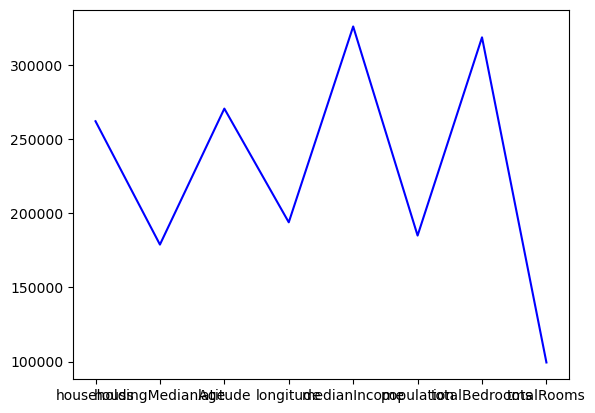

In [87]:
iter_max = 10000
eta = 0.000001

res = sgdregressor (grade = 3,x= data_train,y= target_train,learning= 'adaptive', eta = eta, max = iter_max, estandar = True, grafica = True)

In [ ]:
# Leemos los datos del conjunto de prueba
data_test = pd.read_csv('pliegues/data_test.csv')
target_test = pd.read_csv('pliegues/target_test.csv')

In [ ]:
max = 10000
eta = 0.000001

polynomial_features= PolynomialFeatures(3)
x_poly = polynomial_features.fit_transform(data_train)
x_poly = preprocessing.StandardScaler().fit_transform(x_poly)

x_polyp = polynomial_features.fit_transform(data_test)
x_polyp = preprocessing.StandardScaler().fit_transform(x_polyp)
 
regr = SGDRegressor(learning_rate = learning, eta0 = eta, max_iter= max)
regr.fit(x_poly, target_train.values.ravel())

y_poly_pred = regr.predict(x_polyp)
mse = mean_squared_error(target_test, y_poly_pred)
r2 = r2_score(target_test, y_poly_pred)

print('r='+str(r2))
print('mse='+str(mse))


# Ajustes para que la curva trazada se vea correctamente
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(data_test,y_poly_pred), key=sort_axis)

x_sorted, y_poly_pred = zip(*sorted_zip)
print(pd.DataFrame({'x': np.reshape(x_sorted,(1,-1))[0], 'Predicted': y_poly_pred}))

plt.plot(x_sorted, y_poly_pred, color='b')